In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import statsmodels.api as sm
import talib
import pandas_datareader as pdr
#import sklearn.preprocessing as preprocessing
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set()
from datetime import datetime
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from itertools import compress
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [2]:
'''KOSPI 전체 종목 크롤링 (기존에 데이터가 있다면 크롤링 하지 않아도 무방함) _ 시간 오래걸림 '''

'''
stock_type = {
'kospi': 'stockMkt',
'kosdaq': 'kosdaqMkt'
}
quit()
# 회사명으로 주식 종목 코드를 획득할 수 있도록 하는 함수
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    # 위와같이 code명을 가져오면 앞에 공백이 붙어있는 상황이 발생하여 앞뒤로 sript() 하여 공백 제거
    code = code.strip()
    return code

# download url 조합
def get_download_stock(market_type=None):
    market_type = stock_type[market_type]
    download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
    download_link = download_link + '?method=download'
    download_link = download_link + '&marketType=' + market_type
    df = pd.read_html(download_link, header=0)[0]
    return df

# kospi 종목코드 목록 다운로드
def get_download_kospi():
    df = get_download_stock('kospi')
    df.종목코드 = df.종목코드.map('{:06d}.KS'.format)
    return df

# kosdaq 종목코드 목록 다운로드
def get_download_kosdaq():
    df = get_download_stock('kosdaq')
    df.종목코드 = df.종목코드.map('{:06d}.KQ'.format)
    return df

# kospi, kosdaq 종목코드 각각 다운로드
kospi_df = get_download_kospi()
#kosdaq_df = get_download_kosdaq()

# data frame정리
kospi_df = kospi_df[['회사명', '종목코드']]
#kosdaq_df = kosdaq_df[['회사명', '종목코드']]

# data frame title 변경 '회사명' = name, 종목코드 = 'code'
kospi_df = kospi_df.rename(columns={'회사명': 'name', '종목코드': 'code'})
#kosdaq_df = kosdaq_df.rename(columns={'회사명': 'name', '종목코드': 'code'})


#시계열 데이터 구간 정해주기
start_date = datetime(2001,1,1)
end_date = datetime.now()

#디렉토리 생성
directory = "Data"
path = os.getcwd()
try:
    os.mkdir(path + "/" + directory)
except:
    pass

for i in range(len(kospi_df)):
    try:
        df = pdr.get_data_yahoo(kospi_df.iloc[i,1], start_date, end_date)
        df.to_csv(f'{directory}/{kospi_df.iloc[i,0]}.csv')
    except:
        print(f"Loading Error: {kospi_df.iloc[i,0]}")
        pass

'''

'\nstock_type = {\n\'kospi\': \'stockMkt\',\n\'kosdaq\': \'kosdaqMkt\'\n}\nquit()\n# 회사명으로 주식 종목 코드를 획득할 수 있도록 하는 함수\ndef get_code(df, name):\n    code = df.query("name==\'{}\'".format(name))[\'code\'].to_string(index=False)\n    # 위와같이 code명을 가져오면 앞에 공백이 붙어있는 상황이 발생하여 앞뒤로 sript() 하여 공백 제거\n    code = code.strip()\n    return code\n\n# download url 조합\ndef get_download_stock(market_type=None):\n    market_type = stock_type[market_type]\n    download_link = \'http://kind.krx.co.kr/corpgeneral/corpList.do\'\n    download_link = download_link + \'?method=download\'\n    download_link = download_link + \'&marketType=\' + market_type\n    df = pd.read_html(download_link, header=0)[0]\n    return df\n\n# kospi 종목코드 목록 다운로드\ndef get_download_kospi():\n    df = get_download_stock(\'kospi\')\n    df.종목코드 = df.종목코드.map(\'{:06d}.KS\'.format)\n    return df\n\n# kosdaq 종목코드 목록 다운로드\ndef get_download_kosdaq():\n    df = get_download_stock(\'kosdaq\')\n    df.종목코드 = df.종목코드.map(\'{:06d}.KQ\'.format)

In [3]:
'''외부 시장 데이터 저장 (코스피, 나스닥, s&p500, 다우존스, 환율)'''

'''시계열 데이터 기간과 경로 할당'''
start_date = datetime(2001,1,1)
end_date = datetime.now()

'''디렉토리 생성'''
directory = 'Data_mkt'
path_dir = os.getcwd()
try:
    os.mkdir(path_dir + "/" + directory)
except:
    pass

pdr.get_data_yahoo('^KS11', start_date, end_date).to_csv(f'{path_dir}/{directory}/kospi.csv') #코스피 지수
pdr.get_data_yahoo('^IXIC', start_date, end_date).to_csv(f'{path_dir}/{directory}/nasdaq.csv') #나스닥 지수
pdr.get_data_yahoo('^GSPC', start_date, end_date).to_csv(f'{path_dir}/{directory}/s&p500.csv') #S&P500 지수
pdr.get_data_yahoo('^DJI', start_date, end_date).to_csv(f'{path_dir}/{directory}/dowjones.csv') #DowJones 지수
pdr.get_data_yahoo('KRW=X', start_date, end_date).to_csv(f'{path_dir}/{directory}/exch.csv') #원달러 환율 지수

In [4]:
'''필요한 데이터 불러오기'''

import os
path_dir = os.getcwd()

'''분석하려는 주식 종목'''
asset_name = 'naver'

tmp1 = pd.read_csv(f"{path_dir}/Data/{asset_name}.csv", index_col='Date', parse_dates=['Date']) #자산지수
tmp2 = pd.read_csv(f"{path_dir}/Data_mkt/kospi.csv", index_col='Date', parse_dates=['Date']) #코스피지수
tmp3 = pd.read_csv(f'{path_dir}/Data_mkt/nasdaq.csv', index_col='Date', parse_dates=['Date']) #나스닥 지수
tmp4 = pd.read_csv(f'{path_dir}/Data_mkt/s&p500.csv', index_col='Date', parse_dates=['Date']) #S&P500 지수
tmp5 = pd.read_csv(f'{path_dir}/Data_mkt/dowjones.csv', index_col='Date', parse_dates=['Date']) #DowJones 지수
tmp6 = pd.read_csv(f'{path_dir}/Data_mkt/exch.csv', index_col='Date', parse_dates=['Date']) #원달러 환율 지수
data = [tmp1, tmp2, tmp3, tmp4, tmp5, tmp6]

In [5]:
'''시간 전처리'''

def process_time (df):

    '''가장 짧은 시간으로 통일'''
    start_date_list = []
    end_date_list = []
    for i in df:
        start_date_list.append(i.index[0])
        end_date_list.append(i.index[len(i)-1])
    start_date = max(start_date_list)
    end_date = min(end_date_list)
    date_index = pd.date_range(start_date, end_date)

    '''시간대 맞춰서 데이터 가져오기'''
    tmp = pd.DataFrame(index=date_index)
    for i in df:
        if i is tmp1:
            name = "asset"
        elif i is tmp2:
            name = 'kospi'
        elif i is tmp3:
            name = 'nasdaq'
        elif i is tmp4:
            name = 'snp500'
        elif i is tmp5:
            name = 'dowjones'
        elif i is tmp6:
            name = 'ex_rate'
        for j in i.columns:
            tmp[f'{name}_{j}'] = i[j]
    #tmp 저장 완료

    '''외부데이터 결측치 처리'''
    for row_index, value in tmp.iterrows():
        day = datetime.weekday(row_index)
        if day == (5 or 6):
            tmp.drop(row_index, axis=0, inplace=True)

    '''자산데이터 결측치 처리'''
    tmp_col = tmp.columns
    col_list = []
    for i in range(len(tmp.columns)-1):
        if tmp_col[i][0:5] == "asset":
            col_list.append(tmp_col[i])
    for index, row in tmp[col_list].iterrows():
        if row.isnull().sum() != 0:
            tmp = tmp.drop(index = index)

    '''외부데이터 빈 값, 앞방향 채우기 (당일 휴장으로 인한 과거데이터 연속)'''
    tmp = tmp.fillna(method='ffill')

    return tmp

df = process_time(data)
df

asset_High      asset_Low     asset_Open    asset_Close  \
2003-12-01    6247.093750    5707.776367    5707.776367    6189.893555   
2003-12-02    6336.979980    6071.407227    6275.693848    6157.207520   
2003-12-03    6169.464844    5965.177734    6128.607422    6169.464844   
2003-12-04    6308.379883    6128.607422    6210.322266    6189.893555   
2003-12-05    6328.808594    6108.178711    6128.607422    6153.121582   
...                   ...            ...            ...            ...   
2021-11-30  392500.000000  381000.000000  391000.000000  381000.000000   
2021-12-01  392500.000000  382000.000000  385000.000000  390000.000000   
2021-12-02  399000.000000  382000.000000  382500.000000  398500.000000   
2021-12-03  402000.000000  394500.000000  397500.000000  402000.000000   
2021-12-06  400500.000000  389500.000000  400500.000000  392000.000000   

            asset_Volume  asset_Adj Close   kospi_High    kospi_Low  \
2003-12-01     8806242.0      5836.971191   811.489990   790.799988   
2003-12-02     7112545.0      5806.147949   813.950012   806.299988   
2003-12-03     4547525.0      5817.706055   816.020020   801.080017   
2003-12-04     4459414.0      5836.971191   809.679993   800.309998   
2003-12-05     4439834.0      5802.294434   802.859985   789.409973   
...                  ...              ...          ...          ...   
2021-11-30     1103481.0    381000.000000  2942.929932  2822.729980   
2021-12-01      548840.0    390000.000000  2905.739990  2837.030029   
2021-12-02      613006.0    398500.000000  2945.270020  2874.639893   
2021-12-03      501099.0    402000.000000  2975.439941  2927.550049   
2021-12-06      456773.0    392000.000000  2983.500000  2932.489990   

             kospi_Open  kospi_Close  ...  dowjones_Open  dowjones_Close  \
2003-12-01   796.359985   807.390015  ...    9785.349609     9899.049805   
2003-12-02   813.489990   807.780029  ...    9899.639648     9853.639648   
2003-12-03   807.169983   808.340027  ...    9851.940430     9873.419922   
2003-12-04   805.099976   805.130005  ...    9874.830078     9930.820312   
2003-12-05   802.710022   789.409973  ...    9923.269531     9862.679688   
...                 ...          ...  ...            ...             ...   
2021-11-30  2932.709961  2839.010010  ...   35056.988281    34483.718750   
2021-12-01  2860.120117  2899.719971  ...   34678.941406    34022.039062   
2021-12-02  2874.639893  2945.270020  ...   34076.250000    34639.789062   
2021-12-03  2935.929932  2968.330078  ...   34692.781250    34580.078125   
2021-12-06  2954.820068  2973.250000  ...   34633.429688    35227.031250   

            dowjones_Volume  dowjones_Adj Close  ex_rate_High  ex_rate_Low  \
2003-12-01      227650000.0         9899.049805   1203.500000  1195.000000   
2003-12-02      257640000.0         9853.639648   1198.500000  1186.199951   
2003-12-03      222570000.0         9873.419922   1198.400024  1192.500000   
2003-12-04      267840000.0         9930.820312   1197.900024  1174.800049   
2003-12-05      201640000.0         9862.679688   1193.800049  1178.599976   
...                     ...                 ...           ...          ...   
2021-11-30      678800000.0        34483.718750   1190.959961  1181.709961   
2021-12-01      496000000.0        34022.039062   1184.449951  1159.099976   
2021-12-02      466900000.0        34639.789062   1178.500000  1172.359985   
2021-12-03      439550000.0        34580.078125   1185.099976  1175.439941   
2021-12-06      416720000.0        35227.031250   1185.140015  1178.739990   

            ex_rate_Open  ex_rate_Close  ex_rate_Volume  ex_rate_Adj Close  
2003-12-01   1197.300049    1198.400024             0.0        1198.400024  
2003-12-02   1198.099976    1195.000000             0.0        1195.000000  
2003-12-03   1195.000000    1192.500000             0.0        1192.500000  
2003-12-04   1192.599976    1190.099976             0.0        1190.099976  
2003-12-05   1189.400024    1184.69995

In [6]:
'''변수 데이터 처리'''

def process_factors (df):
    start_date = df.index[0]
    end_date = df.index[len(df)-1]
    date_index = pd.date_range(start_date, end_date)
    tmp = pd.DataFrame(index=date_index)

    '''다음날 등락여부'''
    df['asset_Close_pct'] = df['asset_Close'].pct_change()
    df = df.dropna()
    for i in df.index:
        #if (df.loc[i,'asset_Close'] - df.loc[i,'asset_Open']) > 0:
        if df.loc[i,'asset_Close_pct'] > 0:
            df.loc[i,'signal'] = 1
        else:
            df.loc[i,'signal'] = 0

    df['signal'] = df['signal'].shift(-1) #하루 다음 예측치 이므로 땡겨주기

    '''내재 데이터(가격)'''
    df['asset_high-low_pct'] = (df['asset_High'] - df['asset_Low']).pct_change() #/ df['asset_Low']
    df['asset_close-open_pct'] = (df['asset_Close'] - df['asset_Open']).pct_change() #/ df['asset_Open']
    df['asset_delta_vol_pct'] = df['asset_Volume'].pct_change()

    '''기술 데이터(기술적 지표)'''
    df['MA5_20_ratio'] = talib.SMA(np.asarray(df['asset_Close']), timeperiod=5)/talib.SMA(np.asarray(df['asset_Close']), timeperiod=20)
    df['MA5_20_ratio_pct'] = df['MA5_20_ratio'].pct_change()
    df['MA20_60_ratio'] = talib.SMA(np.asarray(df['asset_Close']), timeperiod=20)/talib.SMA(np.asarray(df['asset_Close']), timeperiod=60)
    df['MA20_60_ratio_pct'] = df['MA20_60_ratio'].pct_change()
    df['RSI14'] = talib.RSI(np.asarray(df['asset_Close']), 14) / 100

    '''외부 데이터(시장 지표)'''
    df['kospi_rtn'] = df['kospi_Close'].pct_change()
    df['nasdaq_rtn'] = df['nasdaq_Close'].pct_change(-1)  #미국과 한국의 시차가 있으니 하루 땡겨주기 (한국시장이 미국시장보다 먼저열림)
    df['snp500_rtn'] = df['snp500_Close'].pct_change(-1)  #미국과 한국의 시차가 있으니 하루 땡겨주기 (한국시장이 미국시장보다 먼저열림)
    df['dowjones_rtn'] = df['dowjones_Close'].pct_change(-1)  #미국과 한국의 시차가 있으니 하루 땡겨주기 (한국시장이 미국시장보다 먼저열림)
    df['ex_rate_pct'] = df['ex_rate_Close'].pct_change()

    '''데이터 분류'''
    feature1 = ['asset_high-low_pct', 'asset_close-open_pct','asset_delta_vol_pct']
    feature2 = ['MA5_20_ratio_pct','MA20_60_ratio_pct','RSI14']
    feature3 = ['kospi_rtn', 'nasdaq_rtn', 'snp500_rtn', 'dowjones_rtn', 'ex_rate_pct']
    feature4 = ['signal']
    X_factors = feature1 + feature2 + feature3
    Y_factors = feature4
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    #df.to_csv('df.csv')

    return df, X_factors, Y_factors

df, X_factors, Y_factors = process_factors(df)
df[X_factors]

asset_high-low_pct  asset_close-open_pct  asset_delta_vol_pct  \
2004-02-24           -0.098362             -0.139534             0.726826   
2004-02-25            0.090911             -0.324324            -0.069947   
2004-02-26            0.866666              2.200000            -0.494097   
2004-02-27           -0.642857             -1.299999            -0.464564   
2004-03-01           -1.000000             -1.000000            -1.000000   
...                        ...                   ...                  ...   
2021-11-26            0.363636              0.500000             0.465805   
2021-11-29            0.200000             -1.000000            -0.034371   
2021-12-01           -0.086957             -1.500000            -0.502629   
2021-12-02            0.619048              2.200000             0.116912   
2021-12-03           -0.558824             -0.718750            -0.182554   

            MA5_20_ratio_pct  MA20_60_ratio_pct     RSI14  kospi_rtn  \
2004-02-24         -0.006806           0.006673  0.544212  -0.014735   
2004-02-25         -0.014033           0.005414  0.494922   0.002637   
2004-02-26         -0.015814           0.004642  0.470226  -0.002319   
2004-02-27         -0.015581           0.003567  0.503274   0.021460   
2004-03-01         -0.012433           0.003010  0.503274   0.000000   
...                      ...                ...       ...        ...   
2021-11-26         -0.005088          -0.000902  0.395216  -0.014707   
2021-11-29         -0.009115          -0.001008  0.378616  -0.009236   
2021-12-01         -0.001018           0.000719  0.426955   0.021384   
2021-12-02          0.002389           0.000204  0.488781   0.015708   
2021-12-03          0.007490           0.001035  0.512122   0.007830   

            nasdaq_rtn  snp500_rtn  dowjones_rtn  ex_rate_pct  
2004-02-24   -0.008670   -0.004005     -0.003325     0.000593  
2004-02-25   -0.004718   -0.001083      0.002030    -0.018049  
2004-02-26    0.001355   -0.000026     -0.000357     0.006041  
2004-02-27   -0.013597   -0.009542     -0.008824     0.006004  
2004-03-01    0.008899    0.005979      0.008182     0.003496  
...                ...         ...           ...          ...  
2021-11-26   -0.018449   -0.013028     -0.006734     0.001970  
2021-11-29    0.015777    0.019328      0.018914     0.003688  
2021-12-01   -0.008274   -0.013996     -0.017834    -0.006618  
2021-12-02    0.019612    0.008521      0.001727    -0.004861  
2021-12-03   -0.009174   -0.011595     -0.018365    -0.000289  

[4166 rows x 11 columns]

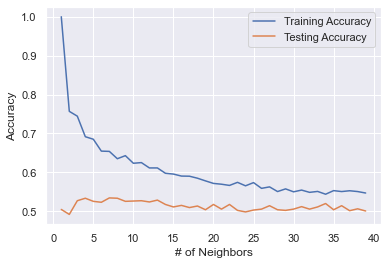

{'k = 1': 50.48, 'k = 2': 49.2, 'k = 3': 52.72, 'k = 4': 53.36, 'k = 5': 52.56, 'k = 6': 52.32, 'k = 7': 53.44, 'k = 8': 53.36, 'k = 9': 52.56, 'k = 10': 52.64, 'k = 11': 52.72, 'k = 12': 52.4, 'k = 13': 52.88, 'k = 14': 51.76, 'k = 15': 51.12, 'k = 16': 51.52, 'k = 17': 50.96, 'k = 18': 51.36, 'k = 19': 50.4, 'k = 20': 51.76, 'k = 21': 50.56, 'k = 22': 51.76, 'k = 23': 50.24, 'k = 24': 49.84, 'k = 25': 50.32, 'k = 26': 50.56, 'k = 27': 51.44, 'k = 28': 50.4, 'k = 29': 50.24, 'k = 30': 50.56, 'k = 31': 51.2, 'k = 32': 50.56, 'k = 33': 51.12, 'k = 34': 52.0, 'k = 35': 50.4, 'k = 36': 51.44, 'k = 37': 50.16, 'k = 38': 50.64, 'k = 39': 50.08}
최대 예측 일치 비율: k = 7: 53.44
최소 예측 일치 비율: k = 2: 49.2

Most Accurate k: 7

테스트 데이터 개수: 1250
예측과 일치한 데이터 개수: 668
일치 비율: 53.44 %
Accuracy : 0.534
Precision : 0.506
Recall : 0.482
F1 : 0.494


In [7]:
'''best_k 찾기'''

def process_knn_k (df, X_factors, Y_factors, train_ratio):

    '''Train, Test분류 (시계열 데이터 이므로 섞지 않는 것이 중요)'''
    X = df[X_factors]
    Y = df[Y_factors[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio, test_size=(1-train_ratio), shuffle=False) #섞지않고

    '''전일 대비 금일의 변화율로 모든 변수의 스케일이 동일 > 정규화 진행 X'''
    #preprocessor = preprocessing.Normalizer()
    #X_train = preprocessor.fit_transform(X_train)
    #X_test = preprocessor.transform(X_test)

    training_accuracy = []
    test_accuracy = []
    dict = {}
    n_test = len(Y_test)
    k_settings = range(1,40)
    for i in k_settings:
        ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=i)
        ploan_knn.fit(X_train, Y_train)
        training_accuracy.append(ploan_knn.score(X_train, Y_train))
        test_accuracy.append(ploan_knn.score(X_test, Y_test))
        Y_predict = ploan_knn.predict(X_test)

        a = round((sum(Y_test == Y_predict)/n_test)*100, 2)
        dict[f'k = {i}'] = a

    plt.plot(k_settings, training_accuracy, label="Training Accuracy")
    plt.plot(k_settings, test_accuracy, label="Testing Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("# of Neighbors")
    plt.legend()
    plt.show()

    print(dict)
    max_dict = max(dict, key=lambda x: dict[x])
    min_dict = min(dict, key=lambda x: dict[x])
    best_k_temp = test_accuracy==max(test_accuracy)
    best_k = list(compress(k_settings, best_k_temp))[0]
    print(f'최대 예측 일치 비율: {max_dict}: {dict.get(max_dict)}')
    print(f'최소 예측 일치 비율: {min_dict}: {dict.get(min_dict)}')
    print('\nMost Accurate k:', best_k)

    '''best k 에서의 모델 성능 평가'''

    best_ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
    best_ploan_knn.fit(X_train, Y_train)
    best_ploan_knn.predict(X_test)

    n_test = len(Y_test)
    Y_predict = best_ploan_knn.predict(X_test)

    print('\n테스트 데이터 개수:', n_test)
    print('예측과 일치한 데이터 개수:', sum(Y_test == Y_predict))
    print('일치 비율:',round((sum(Y_test == Y_predict)/n_test)*100,2),'%')

    accuracy = accuracy_score(Y_test, Y_predict)
    precision = precision_score(Y_test, Y_predict)
    recall = recall_score(Y_test, Y_predict)
    f1 = f1_score(Y_test, Y_predict)
    print('Accuracy : {0:.3f}'.format(accuracy))
    print('Precision : {0:.3f}'.format(precision))
    print('Recall : {0:.3f}'.format(recall))
    print('F1 : {0:.3f}'.format(f1))

    return best_k

best_k = process_knn_k(df, X_factors, Y_factors, 0.7)



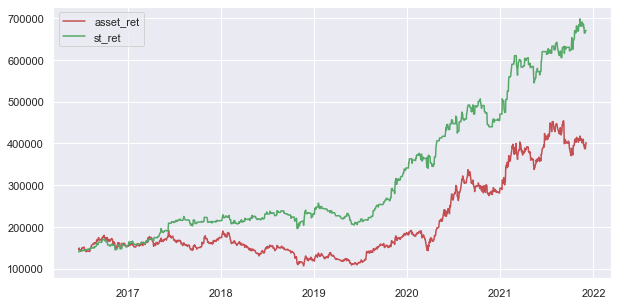

naver's Buy and Hold strategy return: 175.34%
naver's KNN strategy return: 379.43%
naver's Share Ratio: 0.6821210619625723


In [8]:
'''best k와 KNN을 활용한 투자 전략 수익률 테스트'''

def trading_strategy_rtn (best_k, df, X_factors, Y_factors, train_ratio):

    X = df[X_factors]
    Y = df[Y_factors[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio, test_size=(1-train_ratio), shuffle=False) #섞지않고


    best_ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
    best_ploan_knn.fit(X_train, Y_train)
    split = int(train_ratio*len(df))

    '''KNN예측 등락 시그널'''

    df['st_signal'] = best_ploan_knn.predict(X)

    '''초기 투자금'''

    initial_fund = df[split:]['asset_Open'][0]
    #현실의 경우, 투자금이 100만원일 경우 몇주를 사게되는지 따져봐야하지만, 일단은 open가격에 사는것으로 가정

    '''시장 수익률 데이터(시장 종가)'''

    df['mkt_rtn'] = df[split:]['asset_Close']# - df[split:]['asset_Open'][0]
    cum_mkt_rtn = df[split:]['mkt_rtn']

    '''KNN전략 수익률 데이터(일일 매수매도)'''

    df['st_signal'] = df['st_signal'].shift(1) #계산에 활용하기 위해 한칸 미뤄줌
    #df['rtn_pct'] = (df['asset_Close'] - df['asset_Open']) / df['asset_Open']
    df['rtn_pct'] = df['asset_Close'].pct_change()
    #슬리피지의 존재 여부가 수익률에 큰 영향을 주고 있음
    #전날 종가의 가격으로 구매가 가능하다면 큰 수익률을 얻을 수 있으나, 현재의 시가로 구매하게 된다면 수익률이 크게 낮아짐
    #이는 슬리피지로 인한 효과를 생각해야 함을 시사함.

    for i in df[split:].index:
        if df.loc[i, 'st_signal'] == 0:
            df.loc[i, 'st_rtn'] = initial_fund #오르지 않음을 예측시 매수매도가 이뤄지지 않으니 초기투자금 그대로
        else:
            df.loc[i, 'st_rtn'] = ( df.loc[i, 'rtn_pct'] + 1 ) * initial_fund
            initial_fund = df.loc[i, 'st_rtn'] #오른다고 예측시 매수매도 이후, 당일 상승분을 가져감

    df['st_real_rtn'] = df[split:]['st_rtn']# - df[split:]['asset_Open'][0]
    cum_st_rtn = df[split:]['st_real_rtn']

    try:
        os.mkdir(path_dir + "/" + "Data_pic")
    except:
        pass

    plt.figure(figsize=(10,5))
    plt.plot(cum_mkt_rtn, color='r', label='asset_ret')
    plt.plot(cum_st_rtn, color='g', label='st_ret')
    plt.legend()
    plt.savefig(f'{path_dir}/Data_pic/Return Compare on KNN modeling_{asset_name}.png')
    plt.show()

    net_mkt_rtn = ((cum_mkt_rtn[len(cum_mkt_rtn)-1] - cum_mkt_rtn[0]) / cum_mkt_rtn[0]) * 100
    net_st_rtn = ((cum_st_rtn[len(cum_st_rtn)-1] - cum_st_rtn[0]) / cum_st_rtn[0]) * 100
    print(f"{asset_name}'s Buy and Hold strategy return: {round(net_mkt_rtn,2)}%")
    print(f"{asset_name}'s KNN strategy return: {round(net_st_rtn,2)}%")

    #샤프비율로 비교 ( (자산의 기대수익률 - 기준지표의 기대수익률) / 자산 수익률의 표준편차 : 기준지표 대비 초과수익비율)

    std = cum_st_rtn.std()
    sharpe = (cum_st_rtn - cum_mkt_rtn)/std
    sharpe = sharpe.mean()
    print(f"{asset_name}'s Share Ratio: {sharpe}")

trading_strategy_rtn(best_k, df, X_factors, Y_factors, 0.7)

In [9]:
'''
'''코스피 전체 데이터 분석 및 승률 조회'''

'''승률데이터 저장'''
data_dict = {}

'''데이터가 충분히 길지 않아서 저장 안될 경우'''
error_list = []

'''반복용'''
path_dir = os.getcwd()
file_list = os.listdir(f'{path_dir}/Data')

tmp2 = pd.read_csv(f"{path_dir}/Data_mkt/kospi.csv", index_col='Date', parse_dates=['Date']) #코스피지수
tmp3 = pd.read_csv(f'{path_dir}/Data_mkt/nasdaq.csv', index_col='Date', parse_dates=['Date']) #나스닥 지수
tmp4 = pd.read_csv(f'{path_dir}/Data_mkt/s&p500.csv', index_col='Date', parse_dates=['Date']) #S&P500 지수
tmp5 = pd.read_csv(f'{path_dir}/Data_mkt/dowjones.csv', index_col='Date', parse_dates=['Date']) #DowJones 지수
tmp6 = pd.read_csv(f'{path_dir}/Data_mkt/exch.csv', index_col='Date', parse_dates=['Date']) #원달러 환율 지수

for i in file_list:
    try:
        asset_name = i
        tmp1 = pd.read_csv(f"{path_dir}/Data/{i}", index_col='Date', parse_dates=['Date'])
        data = [tmp1, tmp2, tmp3, tmp4, tmp5, tmp6]

        tmp = process_time(data)
        df, X_factors, Y_factors = process_factors(tmp)

        X = df[X_factors]
        Y = df[Y_factors[0]]
        train_ratio = 0.7
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio, test_size=(1-train_ratio), shuffle=False) #섞지않고

        training_accuracy = []
        test_accuracy = []
        k_settings = range(1, 40)

        for k in k_settings:
            ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            ploan_knn.fit(X_train, Y_train)
            training_accuracy.append(ploan_knn.score(X_train, Y_train))
            test_accuracy.append(ploan_knn.score(X_test, Y_test))

        best_k_temp = test_accuracy==max(test_accuracy)
        best_k = list(compress(k_settings, best_k_temp))[0]

        best_ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
        best_ploan_knn.fit(X_train, Y_train)
        split = int(train_ratio*len(df))

        '''KNN예측 등락 시그널'''

        df['st_signal'] = best_ploan_knn.predict(X)

        '''초기 투자금'''

        initial_fund = df[split:]['asset_Open'][0]
        #현실의 경우, 투자금이 100만원일 경우 몇주를 사게되는지 따져봐야하지만, 일단은 open가격에 사는것으로 가정

        '''시장 수익률 데이터(시장 종가)'''

        df['mkt_rtn'] = df[split:]['asset_Close']# - df[split:]['asset_Open'][0]
        cum_mkt_rtn = df[split:]['mkt_rtn']

        '''KNN전략 수익률 데이터(일일 매수매도)'''

        df['st_signal'] = df['st_signal'].shift(1) #계산에 활용하기 위해 한칸 미뤄줌
        #df['rtn_pct'] = (df['asset_Close'] - df['asset_Open']) / df['asset_Open']
        df['rtn_pct'] = df['asset_Close'].pct_change()
        #슬리피지의 존재 여부가 수익률에 큰 영향을 주고 있음
        #전날 종가의 가격으로 구매가 가능하다면 큰 수익률을 얻을 수 있으나, 현재의 시가로 구매하게 된다면 수익률이 크게 낮아짐
        #이는 슬리피지로 인한 효과를 생각해야 함을 시사함.

        for i in df[split:].index:
            if df.loc[i, 'st_signal'] == 0:
                df.loc[i, 'st_rtn'] = initial_fund #오르지 않음을 예측시 매수매도가 이뤄지지 않으니 초기투자금 그대로
            else:
                df.loc[i, 'st_rtn'] = ( df.loc[i, 'rtn_pct'] + 1 ) * initial_fund
                initial_fund = df.loc[i, 'st_rtn'] #오른다고 예측시 매수매도 이후, 당일 상승분을 가져감

        df['st_real_rtn'] = df[split:]['st_rtn']# - df[split:]['asset_Open'][0]
        cum_st_rtn = df[split:]['st_real_rtn']

        '''사진저장 옵션'''

        try:
            os.mkdir(path_dir + "/" + "Data_pic")
        except:
            pass

        plt.figure(figsize=(10,5))
        plt.plot(cum_mkt_rtn, color='r', label='asset_ret')
        plt.plot(cum_st_rtn, color='g', label='st_ret')
        plt.legend()
        plt.savefig(f'{path_dir}/Data_pic/Return Compare on KNN modeling_{asset_name}.png')
        #plt.show()

        #net_mkt_rtn = ((cum_mkt_rtn[len(cum_mkt_rtn)-1] - cum_mkt_rtn[0]) / cum_mkt_rtn[0]) * 100
        #net_st_rtn = ((cum_st_rtn[len(cum_st_rtn)-1] - cum_st_rtn[0]) / cum_st_rtn[0]) * 100
        data_dict[f'{asset_name}'] = cum_st_rtn[len(cum_st_rtn)-1] - cum_mkt_rtn[len(cum_mkt_rtn)-1]
        #print(f"{asset_name}'s Buy and Hold strategy return: {round(net_mkt_rtn,2)}%")
        #print(f"{asset_name}'s KNN strategy return: {round(net_st_rtn,2)}%")

        #샤프비율로 비교 ( (자산의 기대수익률 - 기준지표의 기대수익률) / 자산 수익률의 표준편차 : 기준지표 대비 초과수익비율)

        #std = cum_st_rtn.std()
        #sharpe = (cum_st_rtn - cum_mkt_rtn)/std
        #sharpe = sharpe.mean()
        #print(f"{asset_name}'s Share Ratio: {sharpe}")

    except:
        error_list.append(asset_name)
        pass

        '''


SyntaxError: invalid syntax (Temp/ipykernel_26892/3443384654.py, line 2)